## Попробуем решить задачу классификации изображений на датасете Caltech101

Скачайте датасет по ссылке https://data.caltech.edu/records/20086
Разархивируйте (там будет zip, внутри еще один tar архив `101_ObjectCategories.tar.gz`).

Поместите папку с изображениями `101_ObjectCategories` в ту же директорию, где у вас расположен код (тетрадь юпитер).

In [36]:
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf

In [37]:
data_dir = './datasets/101_ObjectCategories' # путь к датасету

Датасет представляет из себя набор папок с изображениями, где каждая папка соотвествует одному из классов, который мы будем пытататься определять. Это называется *multiclass classification*, то есть многоклассовая классификация, где каждый экземпляр датасета принадлежит только одному классу. Если у одного объекта может быть несколько классов одновременно, то есть меток, задачу называют *multilabel classification*.

In [38]:
from glob import glob

print(glob(data_dir+'/*'))

['./datasets/101_ObjectCategories/okapi', './datasets/101_ObjectCategories/dragonfly', './datasets/101_ObjectCategories/schooner', './datasets/101_ObjectCategories/Faces', './datasets/101_ObjectCategories/stapler', './datasets/101_ObjectCategories/car_side', './datasets/101_ObjectCategories/laptop', './datasets/101_ObjectCategories/revolver', './datasets/101_ObjectCategories/airplanes', './datasets/101_ObjectCategories/gramophone', './datasets/101_ObjectCategories/nautilus', './datasets/101_ObjectCategories/brain', './datasets/101_ObjectCategories/chandelier', './datasets/101_ObjectCategories/lamp', './datasets/101_ObjectCategories/starfish', './datasets/101_ObjectCategories/octopus', './datasets/101_ObjectCategories/flamingo_head', './datasets/101_ObjectCategories/cougar_body', './datasets/101_ObjectCategories/butterfly', './datasets/101_ObjectCategories/cellphone', './datasets/101_ObjectCategories/cougar_face', './datasets/101_ObjectCategories/cup', './datasets/101_ObjectCategories/s

Составим словарь всех изображений, сгруппированных по папкам (классам)

In [39]:
files_dataset = {}

for class_path in glob(data_dir+'/*'):
    class_name = class_path.split('/')[-1]
    files_dataset[class_name] = glob(class_path+'/*')
    

Посчитаем сколько всего у нас классов и сколько изображений в каждом классе

In [40]:
num_of_classes = len(files_dataset)
print('Классов: ', num_of_classes)

Классов:  102


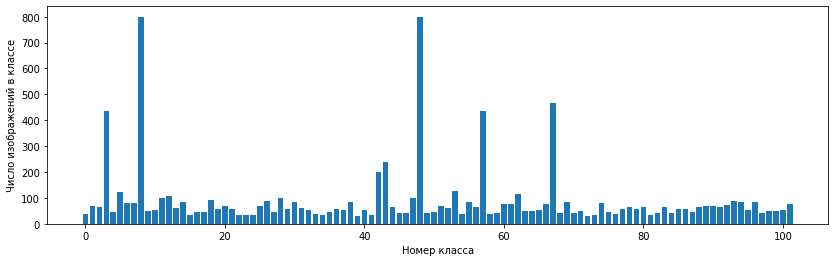

In [41]:
per_class_elems = np.array([len(c) for c in files_dataset.values()])

fig = plt.figure(figsize=(14,4))
plt.bar(range(num_of_classes), per_class_elems)
plt.xlabel('Номер класса')
plt.ylabel('Число изображений в классе')
plt.show()

Как мы видим датасет - несбалансированный, некоторые классы значительно превосходят по числу объектов другие классы. Это плохо для большинства алгоритмов обучения. Если мы не предпримем дополнительные меры, то при обучении минимизация ошибка будет идти по самым объемным классам, так как они будут в основном вкладывать наибольшую долю в ошибку (из-за большего числа элементов).

Мы же стремимся обучить систему классифицировать *все классы* данного датасета одинаково хорошо. Существует множество способов работы с подобными датасетами. См. _unbalanced datasets_.

Посчитаем число элементов в самом большом, в самом маленьком классах, и среднее (медианное) число объектов на класс. Среднее считать не будем, так как такая оценка сильно подвержена аномалиям (редким чрезмерно большим или малым классам), которые, очевидно, присутствуют в нашем датасете.

In [ ]:
max_elems = np.amax(per_class_elems)
min_elems = np.amin(per_class_elems)
median_elems = np.median(per_class_elems)

print('Минимальное число изображений в классе: ', min_elems)
print('Максимальное число изображений в классе: ', max_elems)
print('Медианное число изображений в классе: ', median_elems)

Минимальное число изображений в классе:  31
Максимальное число изображений в классе:  800
Медианное число изображений в классе:  59.0


## Как подготовить датасет для обучения

In [43]:
batch_size = 16
height = 200
width = 300
validation_split = 0.2

### не рекомендуется

Для подобного датасета, организованного по папкам, можно воспользоваться встроенной в Keras функцией чтения датасета

In [ ]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(height, width),
    shuffle=True,
    seed=1,
    validation_split=validation_split,
    subset="training",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
).map(lambda x,y: (x / 255.0,y))

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(height, width),
    shuffle=False,
    seed=1,
    validation_split=validation_split,
    subset="validation",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
).map(lambda x,y: (x / 255.0,y))

А можно сделать это самим (практически всегда лучше, так как больше контроля), тем более мы уже подготовили списки файлов и классов. Еще одним плюсом будет то, что мы сможем случайным образом разделить каждый класс на тренировочный и тестовый набор, и у нас не возникнет ситуации, когда один из датасетов не попал (или попал в неправильном соотношении) в обучающую выборку (или тестовую).

In [44]:
def make_tfdata(x, i):
    part = int((1-validation_split)*len(x))
    x = (
        tf.data.Dataset.from_tensor_slices(x) # создаем экземпляр класса tf.data.Dataset
         .shuffle(len(x), reshuffle_each_iteration=False) # перемешиваем внутри класса 1 раз
         .map(lambda x: (x,i)) # добавляем метку класса каждому элементу внутри класса
        )
    train_x = (
        x.take(part) # берем первые part элементов датасета для тренировочной выборки
        .shuffle(part, reshuffle_each_iteration=True) # перемешиваем тренировочный датасет каждый раз, когда датасет перебран полностью
    )
    test_x = x.skip(part) # пропускае первые part элементов и берем все последующие для тестовой выборки
    return train_x, test_x

train_datasets = []
test_datasets = []
for i,x in enumerate(files_dataset.values()):
    train_d, test_d = make_tfdata(x,i)
    train_datasets.append(train_d)
    test_datasets.append(test_d)
# здесь у нас есть список пар "тренировочная выборка" и "тестовая выборка" по каждому классу отдельно
# + мы добавили соотвествующие номера классов для всех элементов

Теперь нужно решить вопрос с тем, что датасет несбалансирован. Один из хороших способов - это семплировать (случайным образом вытаскивать из датасета) элементы каждого класса с одинаковой вероятностью. Для этого существует встроенная функция в tensorflow `tf.data.Dataset.sample_from_datasets()`. При необходимости у данной функции есть параметр `weights`, он позволяет задать желаемое распределение (вероятности для каждого датасета) явно, если нужно что-то отличное от равновероятного.

Также иногда бывает удобнее использовать метод `tf.data.Dataset.rejection_resample()`.

In [51]:
train_dataset = tf.data.Dataset.sample_from_datasets(train_datasets, stop_on_empty_dataset=True)
test_dataset = tf.data.Dataset.sample_from_datasets(test_datasets, stop_on_empty_dataset=True)

Рассмотрим небольшой пример. Пусть у нас есть 3 класса - 1 однозначное число, 3 двухзначных числа и 10 трехзначных чисел.
Сперва сделаем объединенный датасет из этих 3 классов путем сэмплирования, повторим прогон несколько раз, так как обход датасета может резко прерваться (если за один проход мы два раза попытаемся вытащить элемент из 1-ого класса) и выведем результат.

In [124]:
test_d_0 = tf.data.Dataset.range(20, 21).shuffle(1000, reshuffle_each_iteration=True)
test_d_1 = tf.data.Dataset.range(0, 3).shuffle(1000, reshuffle_each_iteration=True)
test_d_2 = tf.data.Dataset.range(100, 110).shuffle(1000, reshuffle_each_iteration=True)
combo_d = tf.data.Dataset.sample_from_datasets([test_d_0, test_d_1, test_d_2], stop_on_empty_dataset=True)

list_combo_d = list(combo_d.repeat(4).as_numpy_iterator())

print(list_combo_d)
print(len(list_combo_d))

[1, 20, 102, 2, 0, 108, 20, 2, 109, 1, 20, 101, 108, 100, 20, 109]
16


In [250]:
list(combo_d.batch(4, drop_remainder=True).repeat(5).as_numpy_iterator())

[array([100,   1, 109,  20]),
 array([  0,   2, 105, 108]),
 array([ 20, 103,   0,   2]),
 array([ 20, 101, 103, 107]),
 array([100, 109, 108, 106])]

Теперь попробуем просто склеить датасеты классов и перемешать элементы в нем.

In [142]:
concat_d = (
    test_d_0
    .concatenate(test_d_1)
    .concatenate(test_d_2)
    .shuffle(1000)
)

list_concat_d = list(concat_d.as_numpy_iterator())

print(list_concat_d)
print(len(list_concat_d))

[106, 2, 0, 100, 109, 101, 20, 108, 105, 102, 107, 104, 1, 103]
14


Обратите внимание на то, сколько раз нам встретилось единственное двухзначное число (20) в нашем датасете в случае сэмплирования, и без него. 

Но есть и некоторые трудности при таком подходе:

1. Вероятность переобучения на малообъемных классах возрастает, модель может просто "запомнить" небольшой набор повторяющихся представителей небольшого класса. В некоторых случаях, имеет смысл давать меньший весь малым классам;
2. Мы уже не можем напрямую пользоваться "понятием" эпоха обучения, то есть числом циклов полного обхода датасета. В лучшем случае мы можем оценить - сколько раз нам нужно обойти такой "сэмплированный" датасет, которой при каждом обходе может иметь разное число экземпляров, чтобы в среднем за один обход мы как минимум 1 раз встретили каждый экземпляр общего датасета. (Для редактора: В идеале попробовать оценить необходимое число повторений :))

Еще один вариант ребалансировки датасета - брать из каждого класса медианное или некоторое другое среднее число случайных экземпляров (если в классе меньше элементов - брать все), после перемешивая получившуюся выборку. Реализация на tensorflow приведена ниже.

In [281]:
d_median = np.median([len(test_d_0), len(test_d_1), len(test_d_2)])
print(d_median)
concat_d_portion = (
    test_d_0.take(d_median)
    .concatenate(test_d_1.take(d_median))
    .concatenate(test_d_2.take(d_median))
    .shuffle(1000)
)

3.0


In [282]:
list_concat_d = list(concat_d_portion.as_numpy_iterator())

print(list_concat_d)
print(len(list_concat_d))

[102, 0, 104, 20, 2, 1, 109]
7


Плюсом такого подхода будет фиксированное число элементов в одном проходе датасета, но при этом аномально малые по числу экземпляров классы будут представлены реже, чем в случае предыдущей балансировки, хотя, при этом вероятность переобучения на таких малых классах - п

Для сравнения, вы можете попробовать не проводить балансировку датасета и все равно обучить модель. В этом случае нам не нужно перемешивать элементы внутри каждого датасета классов (тренировочная выборка), но хуже от этого не будет (больше вычислений, но для данной задачи - это не критично), поэтому код `make_tfdata()` выше можно не менять.

In [ ]:
from functools import reduce

# далее мы просто соединяем все датасеты классов в один общий
train_dataset = reduce(lambda prev_d, d: prev_d.concatenate(d), train_datasets)
test_dataset = reduce(lambda prev_d, d: prev_d.concatenate(d), test_dataset)

# мы не сэмплируем элементы датасетов в данном случае, 
# поэтому единый датасет необходимо перемешивать после каждого полного прохода.
train_dataset = train_dataset.shuffle(len(train_dataset), reshuffle_each_iteration=True)

Теперь нам нужно преобразовать датасет в вид пригодный для обучения (и использования) нашей модели.
Для этого нужно преобразовать каждый элемент тренировочного и тестового датасета (сейчас это пара "путь к картинке + номер класса") в пару "массив изображения + закодированная метка класса".

In [52]:
def prepare_pair(x,y):
    y = tf.one_hot(y, num_of_classes) # кодируем метку
    x = tf.io.read_file(x) # считываем файл
    x = tf.io.decode_jpeg(x, channels=3) # переводим jpeg в 3D массив высота*ширина*число_канналов
    x = tf.image.resize(x, [height, width]) # меняем размер изображение на заранее указанный
    # это не идеальный вариант, в некоторых случаях он не подходит, так как мы можем нарушить соотношение сторон
    # и исказить изображений, в нашем случае это не так страшно, вариант лучше это обрезать изображение
    # или добавлять поля к изображению для достижения заранее заданного соотношения, а потом уже менять размер.
    # Можно также использовать такие архитектуры моделей (нейросетей), который будут способны работать с различными
    # размера входных данных, но пока тоже отложим.
    
    x *= 1/255 # отмасштабируем все цветовые значения в диапазоне от 0 до 1
    
    return x, y

# сперва мы сделаем пачку из элементов датасета,
# так как написанная нами prepare_pair использует функции tensorflow, 
# каждая из которых, может работать одновременно на наборе изображений,
# это позволяет параллелить чтение/обработку. Не всегда так получается :(
train_dataset = (
    train_dataset
    .map(lambda x,y: prepare_pair(x,y))
    .batch(batch_size, drop_remainder=True) # группируем датасет пачками размера batch_size
)

test_dataset = (
    test_dataset
    .map(lambda x,y: prepare_pair(x,y))
    .batch(batch_size, drop_remainder=True)
)

Посмотрим как выглядит один из элементов нашего датасета

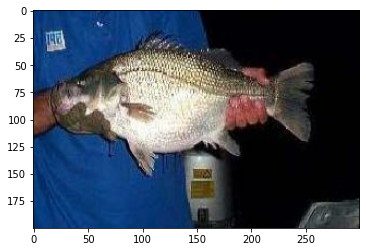

Это bass
Номер класса 100
Закодированная метка класса [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0.]


In [53]:
for x,y in train_dataset.take(1):
    plt.imshow(x[0])
    plt.show()
    
    print('Это', list(files_dataset.keys())[tf.argmax(y[0]).numpy()])
    print('Номер класса', tf.argmax(y[0]).numpy())
    print('Закодированная метка класса', y[0].numpy())

Еще один очень важный прием, который позволяет искусственно "обогатить" датасет называется аугментацией.

Аугментация - это икусственное увеличение числа элементов в датасете. Задача сама по себе очень сложная и интересная.
Существует очень много способов (вплоть до применения других нейросетей) аугментации данных, эти способы еще отличаются
по виду данных для которых они были созданы (текст, изображение и т.д.). Существуют также универсальные методы.

Мы воспользуемся максимально простой аугментацией изображений - случайные отражения, повороты и аддитивный гауссов шум. Причем выполнять эти
преобразования мы будем на лету, в процессе прохождения по датасету и каждый раз случайно. В общем случае, выбор аугментации
зависит от задачи - действительно ли значение $y$ не меняется поле того или иного изменения $x$. Важно понимать,
что аугментация имеет свои пределы и не способна качественно заменить "настоящее" поплнение датасета. С аугментацией
модель становится инварианта (только если после аугментации не меняется $y$, если меняется, то мы должны понимать как именно, иначе аугментация может быть бессмысленной) относительного некоторого преобразование (например поворот изображения и объектов на нем) и также аугментация помогает бороться с переобучением.

Особо вычислительно сложные преобразование можно выполнять уже на GPU непосредственно перед подсчетом функции ошибки.
В нашем же случае достаточно будет CPU, поэтому добавим еще одно преобразование тренировочной выборке с помощью  метода `.map()`.

In [54]:
import tensorflow_addons as tfa

def augment(x,y):
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)
    random_angle_radians = tf.random.uniform([batch_size], minval=-1.0, maxval=1.0)
    x = tfa.image.rotate(x, random_angle_radians, interpolation='bilinear')
    
    add_noise = tf.random.uniform([], minval=0, maxval=2)
    if add_noise == 0:
        #без шума
        x = x
    elif add_noise == 1:
        #слабый шум
        x = x + tf.random.normal(x.shape, mean=0.0, stddev=0.1)
    elif add_noise == 2:
        #сильный шум
        x = x + tf.random.normal(x.shape, mean=0.0, stddev=0.2)
    
    x = tf.clip_by_value(x, 0.0, 1.0) # после добавления шума, значения могут немного вылезти за пределы 0 и 1,
    # поэтому обрежем эти значения до ближайших
    return x,y

train_dataset = train_dataset.map(lambda x,y: augment(x,y))

Посмотрим как теперь выглядит датасет

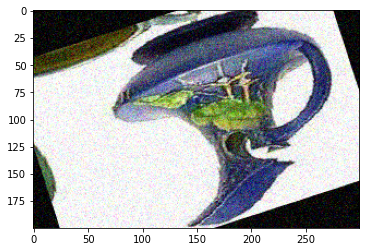

Это ewer
Номер класса 69
Закодированная метка класса [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


In [55]:
for x,y in train_dataset.take(1):
    plt.imshow(x[0])
    plt.show()
    
    print('Это', list(files_dataset.keys())[tf.argmax(y[0]).numpy()])
    print('Номер класса', tf.argmax(y[0]).numpy())
    print('Закодированная метка класса', y[0].numpy())

Можете также попробовать не добавлять аугментацию (не выполнять код выыше) и посмотреть как это скажется на обучение и качестве работы модели.

Далее сделаем еще одну полезную вещь. Добавим инструкцию подгружать (и обрабатывать) элементы (или батчи) датасета до того, как они будут запрошены в процессе обучения. Это снижаем временную задержку между подготовкой данных в ОП и отправкой их на обучение модели в CPU или GPU.

In [33]:
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

## Строим модели, обучаем, проверяем качество

- Dense - слишком много параметров
- Кастомное обучение vs keras + создание классов типа keras.Model
- CNN с нуля
- CNN с нуля + слои регуляризации
- CNN + transfer learning 